In [1]:
library(tidyverse)
library(data.table)
library(EvolutionaryGames)
library(ggthemes)
library(latex2exp)
library(ggtext)

setwd("D:/R/RStudio/project/PLA20220817")


duplicate_dynamic<-function(y,x=0.5,M,beta,d,N,c){
  
  #-----参数解释说明------#
  # #N个个体
  # N<-4
  # #M资源 c(5,15,25)
  # M<-5
  # #less effort的成本
  # c<-1
  # #投入效用
  # beta<-1
  # #more effort的成本
  # d<-4
  #合作中躺平的比例
  x<-0.5
  #内卷相对躺平的效用
  beta1<-4
  #合作相对躺平的效用
  beta2<-2
  #躺平的成本
  l<-0.1
  #-----------------------#
  
  #这里决定用N-1
  #需要取整
  #Nd<-floor(y*(N-1))  #我重新尝试了取整，没有报错
  Nd<-floor(y*(N-1))
  Nc<-floor((N-1)*(1-y)*x)
  Nl<-N-1-Nd-Nc
  
  #策略d(defect，more effort)\策略c（cooperate, less effort）\策略躺平l（lay down）的收益
  #（1）个体选择策略d的期望收益
  pai_d<-(beta1*d*M)/((Nd+1)*beta1*d+Nc*beta2*c+Nl*l)-d
  #（2）个体选择策略c的期望收益
  pai_c<-(beta2*c*M)/(Nd*beta1*d+(Nc+1)*beta2*c+Nl*l)-c
  #(3)个体选择策略l的期望收益
  pai_l<-(beta2*c*M)/(Nd*beta1*d+Nc*beta2*c+(Nl+1)*l)-l
  
  #群体体选择策略c或d的收益  = 概率*pai
  #等价Pc<(choose(N-1, Nc)*((1-y)^Nc)*(y^Nd))*pai_c
  # Pc<-(choose(N-1, Nd)*(y^Nd)*((1-y)^Nc))*pai_c
  # Pd<-(choose(N-1, Nd)*(y^Nd)*((1-y)^Nc))*pai_d #choose计算组合数
  
  #n即Nd,累加收集概率 
  #每种策略，所有该人群的期望收益
  Pc<-0
  Pd<-0
  Pl<-0
  for(n in 0:(N-1)){  
    Pd<-Pd+(choose(N-1, n)*(y^n)*((1-y)^(N-1-n)))*pai_d
    Pc<-Pc+(choose(N-1, n)*(y^Nd) *((1-y)*x)^n*((1-y)*(1-x))^(N-1-Nd-Nc))*pai_c
    Pl<-Pl+(choose(N-1, n)*(y^Nd) *((1-y)*x)^Nc*((1-y)*(1-x))^n)*pai_l
  }
  
  #（3）群体策略的期望收益
  R_<-y*Pd+(1-y)*x*Pc+(1-y)*(1-x)*Pl
  
  #(4)复制动态方程
  #
  y.<-ifelse(is.na(y*(Pd-R_)),0,y*(Pd-R_)) 
}  

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




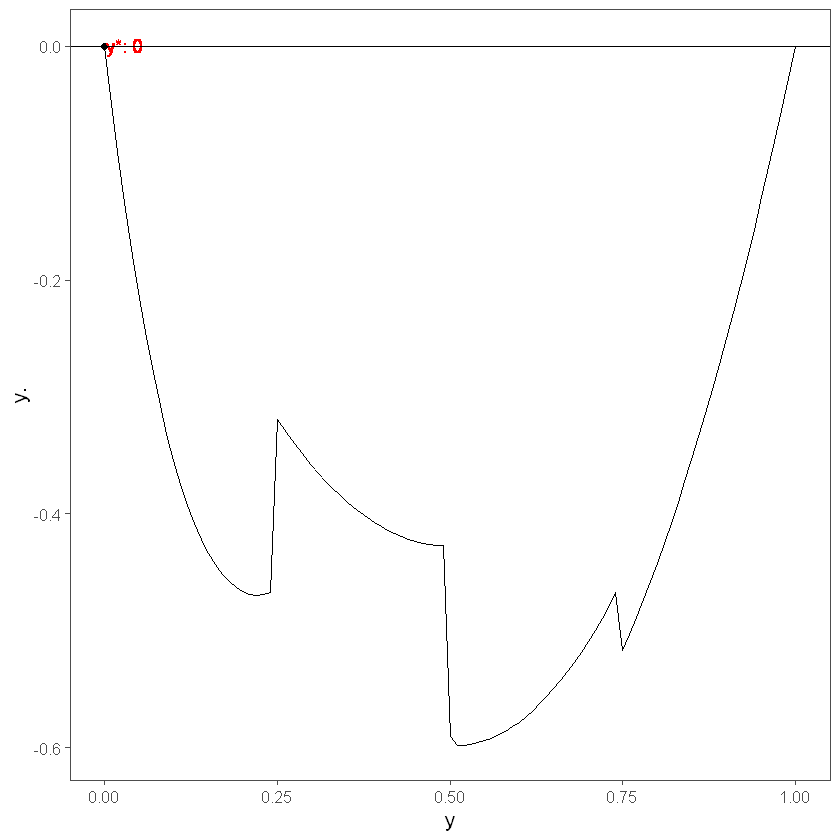

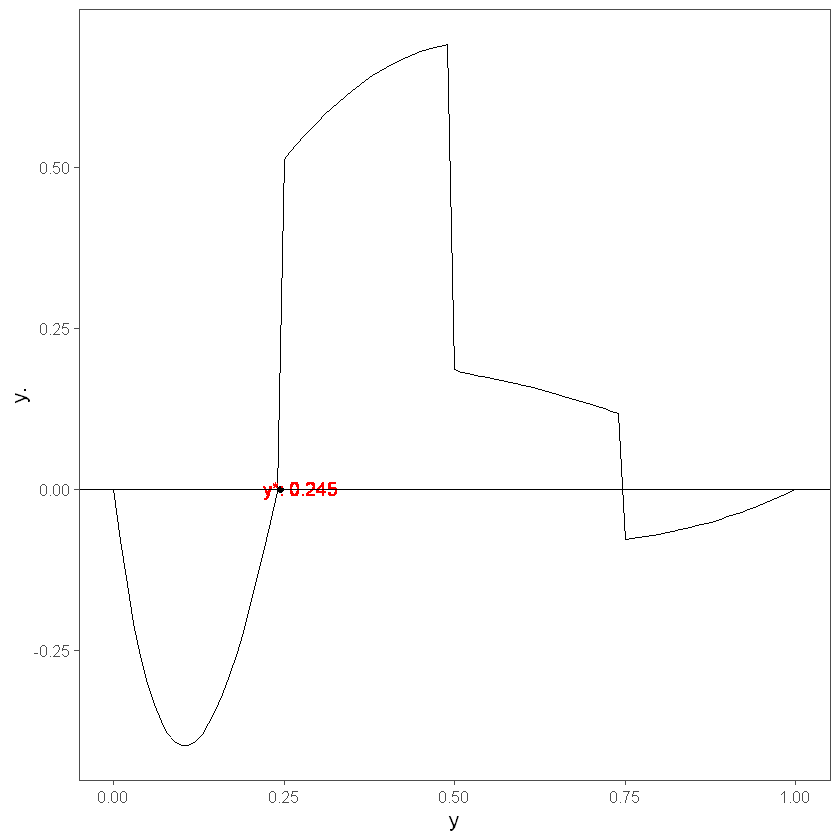

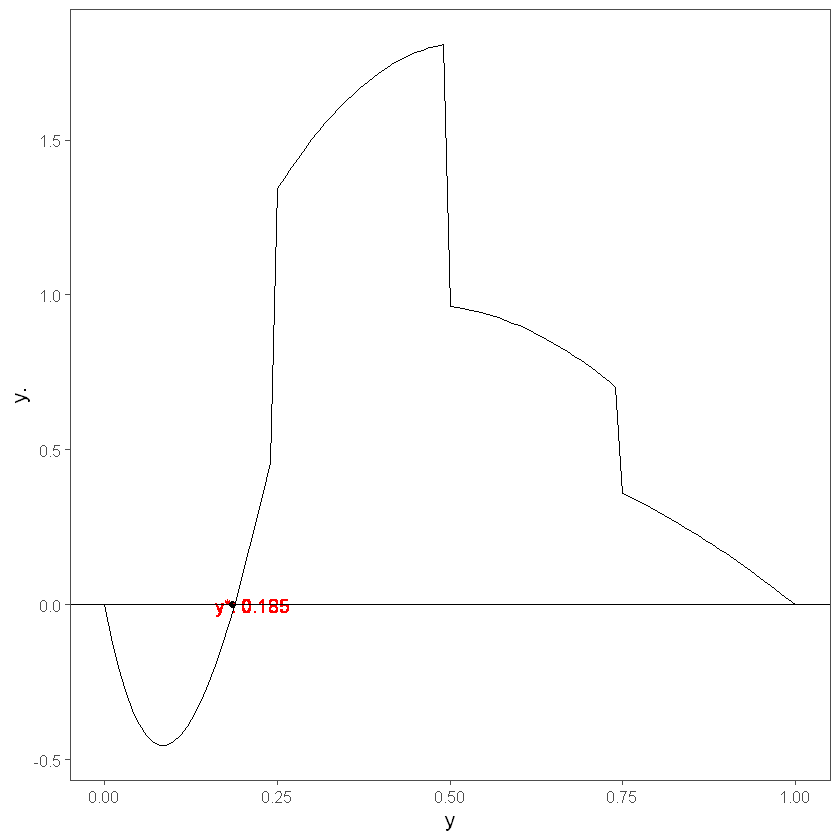

In [2]:
#----------------------------------------------------------------------#
#------------------------------图1-------------------------------------#
#----------------------------------------------------------------------#
plot_y._y<-function(M){
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,x=0.5,M,beta=1,d=4,N=5,c=1) #调整N=5，即可用M=5,15,25复现
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)#通过前一项与后一项相乘是否小于0，来获取临界点ystar
  
  #ystar<-df$x[df$y0<0]+0.005 #即横坐标，因为是以0.01为步长移动，取0.005为均值加上
  
  ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  
  ggplot(df,aes(x=x,y=y))+
    geom_line(color="black",size=0.3)+
    theme_few() +
    geom_point(aes(x=ystar,y=0))+
    geom_text(aes(x=ystar,y=0),label=paste("y*:",ystar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
    geom_hline(aes(yintercept = 0),size=0.3)+
    labs(x = "y", y = "y.")
}


#---1. fig1 (a1)---#
plot_y._y(M=5)

#---2. fig1 (b1)---#
plot_y._y(M=15)

#---3. fig1 (c1)---#
plot_y._y(M=25)#右临界资源值

#调整N=5，即可用M=5,15,25复现
#plot_y._y(M=25)

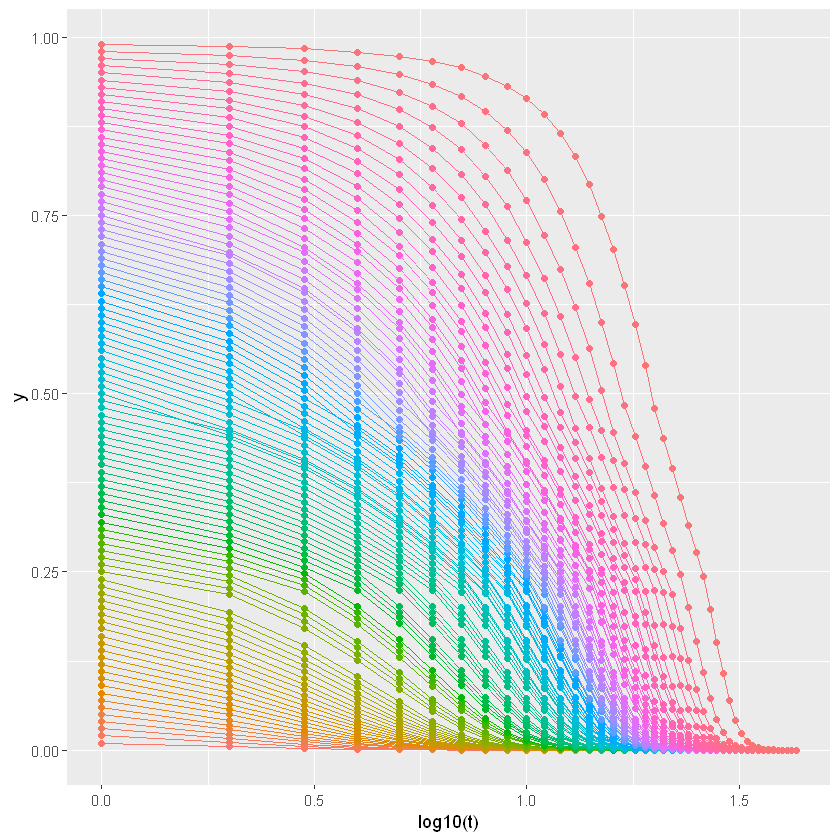

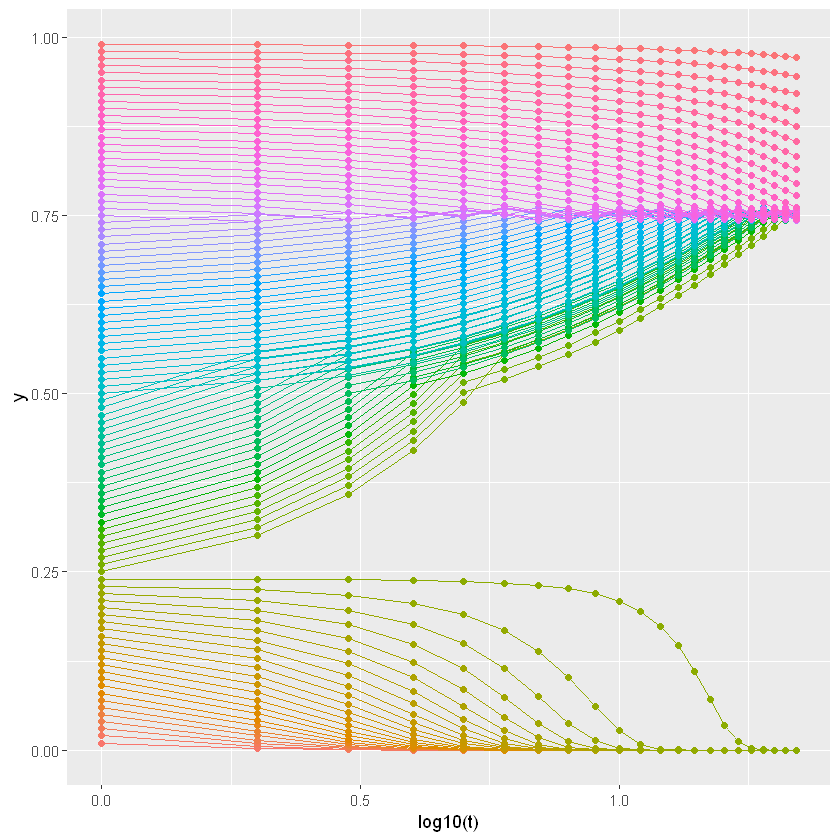

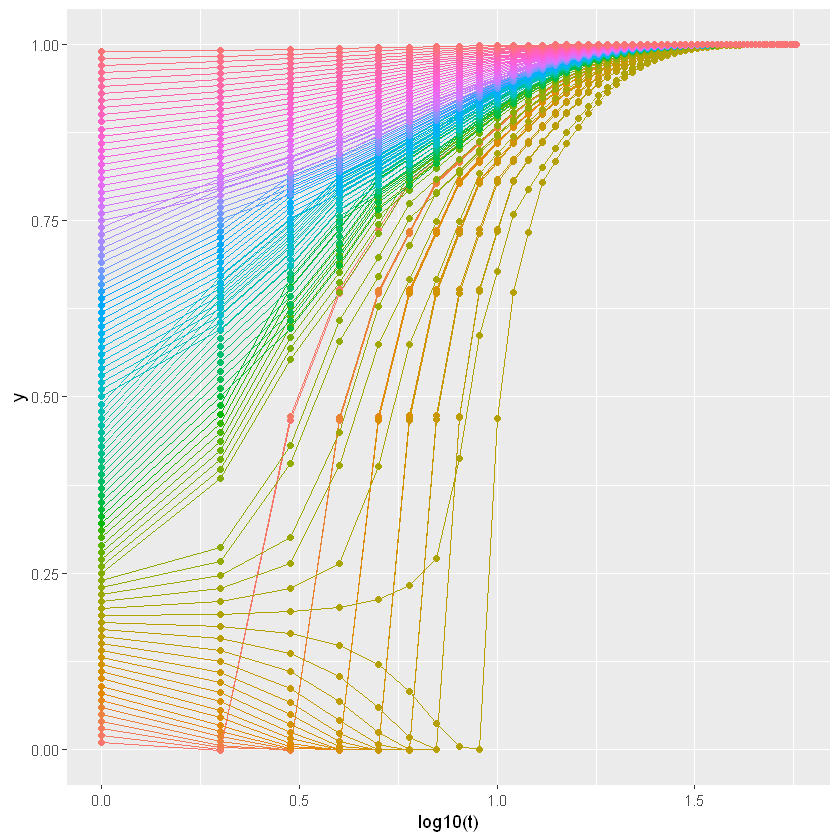

In [3]:
#----------------------------------------------------------------------------#
#------------------------------图1（下）-------------------------------------#
#----------------------------------------------------------------------------#
plot_t <- function(M){
  steps = 500
  endings = c()
  df = data.frame()
  #gp = ggplot(x = seq(1,steps+1,1))
  
  #初始y=0.5,观察迭代多少步到达y_star
  interval<-seq(0.01,0.99,0.01)  #上限不能取到1，否则会多条直线
  
  # 找到要跑多少步
  for (starting in interval){
    t = seq(1,steps,1)
    y<-starting
    
    for (i in t){
      y. = duplicate_dynamic(y[length(y)],x=0.5,M,beta = 1,d = 4,N = 5,c = 1)
      if (abs(y.) <0.0001){ #趋近于0即可
        endings = c(endings,i)
        break
      }
      y = c(y,y.*0.1 + y[length(y)])
    }
  }
  ending = max(endings)
  
  # 按最大步数再跑一遍
  for (starting in interval){
    t = seq(1,ending,1)
    y = c(starting)
    for (i in t){
      y. = duplicate_dynamic(y[length(y)],x=0.5,M,beta = 1,d = 4,N = 5,c = 1)
      y = c(y,y. * 0.1 + y[length(y)])
    }
    df = rbind(df,data.frame(label=rep(as.character(starting),length(y)),x=seq(1,ending+1,1),y=y))
  }
  ggplot(df,aes(x=log10(x),y=y,color=label))+
    geom_line()+
    xlab("log10(t)")+
    geom_point()+
    theme(legend.position="none")
}

plot_t(M=5)

plot_t(M=15)

plot_t(M=25)

In [11]:
#----------------------------------------------------------------------#
#------------------------------图2-------------------------------------#
#----------------------------------------------------------------------#
ystar_collect<-function(M,beta,d){
  
    ystar = 0
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,x=0.5,M,beta,d,N=5,c=1)
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)
    df[is.na(df)] <- 0  
  #ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  if(all(df$y<=0)){
    ystar<-0 
  }else if(all(df$y>0)){
    ystar<-1
  }else{
    ystar<-df$x[df$y0<0]+0.005
  }
  if(length(ystar) == 0){
      ystar = 1
  }
  
  return(ystar)
}
#均衡ystar值收集
parameters<-data.frame(beta=c(1,1,1,0.6,0.6,0.6),d=c(2,4,8,2,4,8))

result<-data.frame()

for(i in 1:6){
  beta<-parameters$beta[i]
  d<-parameters$d[i]
  
  ystars<-c()
  
  for (M in seq(0,50,1)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(beta=rep(beta,length(ystars)),d=rep(d,length(ystars)),M=seq(0,50,1),ystar=ystars)
  
  result<-rbind(result,data)
}
#数据可视化
df<-result %>% 
  mutate(label=paste("beta=",beta,",","d=",d,sep=""))

ggplot(df,aes(x=M,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

ERROR: Error in data.frame(beta = rep(beta, length(ystars)), d = rep(d, length(ystars)), : arguments imply differing number of rows: 56, 51


In [ ]:
#----------------------------------------------------------------------#
#------------------------------图3-------------------------------------#
#----------------------------------------------------------------------#
#均衡ystar值收集
parameters<-data.frame(M=c(500,500,500,250,250,250),d=c(2,4,8,2,4,8))
result<-data.frame()

for(i in 1:6){
  M<-parameters$M[i]
  d<-parameters$d[i]
  
  ystars<-c()
  
  for (beta in seq(0.02,1.2,0.02)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(M=rep(M,length(ystars)),d=rep(d,length(ystars)),beta=seq(0.02,1.2,0.02),ystar=ystars)
  
  result<-rbind(result,data)
}

#数据可视化
df<-result %>% 
  mutate(label=paste("M=",M,",","d=",d,sep=""))

ggplot(df,aes(x=beta,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

In [ ]:
#----------------------------------------------------------------------#
#------------------------------图4-------------------------------------#
#----------------------------------------------------------------------#
#均衡ystar值收集
parameters<-data.frame(beta=c(1,1,1,0.6,0.6,0.6),M=c(250,400,500,250,400,500))
result<-data.frame()

for(i in 1:6){
  beta<-parameters$beta[i]
  M<-parameters$M[i]
  
  ystars<-c()
  
  for (d in seq(1.1,20,0.5)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(beta=rep(beta,length(ystars)),M=rep(M,length(ystars)),d=seq(1.1,20,0.5),ystar=ystars)
  
  result<-rbind(result,data)
}

#数据可视化
df<-result %>% 
  mutate(label=paste("beta=",beta,",","M=",M,sep=""))

ggplot(df,aes(x=d,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

In [ ]:
#----------------------------------------------------------------------#
#------------------------------图5-------------------------------------#
#----------------------------------------------------------------------#
library(progress)

#均衡ystar值收集
result<-data.frame()
beta1<-0.6
pb <- progress_bar$new(format = "  完成百分比 [:bar] :percent 执行时间 :elapsed:elapsedfull",total = 40, clear = FALSE, width= 60)
for(M in seq(1,400,10)){
  pb$tick()
  for(d in 1:20){
    ystars<-c()
    
    for (beta in seq(0.02,1.2,0.02)){
      temp<-ystar_collect(M,beta=beta1,d)
      ystars<-c(ystars,temp)
    }
    
    data<-data.frame(M=M,d=d,beta=beta1,ystar=ystars)
    
    result<-rbind(result,data)
  }
}

ggplot(result,aes(x=d,y=M,fill=ystar))+
  geom_raster() +
  scale_fill_gradientn(colours =rainbow(7,start=min(result$ystar),end=max(result$ystar)))+
  theme_few()+
  guides(fill=guide_colorbar(title= expression(y^.),title.hjust =  .2))

ggsave("fig5-beta=0.6.png",width=15, height=13,units="cm",dpi = 600)
